In [1]:
# !pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from joblib import dump

2024-04-27 10:48:29.749098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df_kdd = pd.read_pickle("./data/KDDCUP/KDDCUP_DF_Preprocessed.pkl")
df_kdd.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
277491,0,2,0,105,147,0,0,0,0,0,...,253,0.99,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0
41454,0,0,0,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1
102006,0,0,0,520,0,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1
398265,0,0,0,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1
24912,0,1,1,0,0,0,0,0,0,0,...,23,0.09,0.05,0.0,0.0,1.0,1.0,0.0,0.0,1


In [4]:
y = df_kdd[['Attack Type']]
X = df_kdd.drop(columns=['Attack Type'], axis=1)

In [5]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X Type: {} Shape: {}".format(type(X), X.shape))
print("y Type: {} Shape: {}".format(type(y), y.shape))

print("X_train Type: {} Shape: {}".format(type(X_train), X_train.shape))
print("y_train Type: {} Shape: {}".format(type(y_train), y_train.shape))

print("X_test Type: {} Shape: {}".format(type(X_test), X_test.shape))
print("y_test Type: {} Shape: {}".format(type(y_test), y_test.shape))

X Type: <class 'numpy.ndarray'> Shape: (395216, 40)
y Type: <class 'pandas.core.frame.DataFrame'> Shape: (395216, 1)
X_train Type: <class 'numpy.ndarray'> Shape: (316172, 40)
y_train Type: <class 'pandas.core.frame.DataFrame'> Shape: (316172, 1)
X_test Type: <class 'numpy.ndarray'> Shape: (79044, 40)
y_test Type: <class 'pandas.core.frame.DataFrame'> Shape: (79044, 1)


In [8]:
model_gnb = GaussianNB()
start_time = time.time()
model_gnb.fit(X_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time - start_time)

Training time:  0.304218053817749


In [9]:
print("Train score: ", model_gnb.score(X_train, y_train))
print("Test score: ", model_gnb.score(X_test, y_test))

Train score:  0.985488911099022
Test score:  0.9851475127776934


In [10]:
model_rfc = RandomForestClassifier(n_estimators=20)
start_time = time.time()
model_rfc.fit(X_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time - start_time)

Training time:  3.701658248901367


In [11]:
print("Train score: ", model_rfc.score(X_train, y_train))
print("Test score: ", model_rfc.score(X_test, y_test))

Train score:  1.0
Test score:  0.9997596275492131


In [12]:
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length + 1):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

In [13]:
seq_length = 1  # Specify your sequence length here

X_train_seq = create_sequences(X_train, seq_length)
X_test_seq = create_sequences(X_test, seq_length)

X_train_seq = X_train_seq.reshape((-1, seq_length, X_train.shape[1]))
X_test_seq = X_test_seq.reshape((-1, seq_length, X_test.shape[1]))

y_train_seq = y_train[seq_length - 1:]
y_test_seq = y_test[seq_length - 1:]

In [14]:
model_lstm = Sequential([
    LSTM(5, input_shape=(seq_length, X_train.shape[1])),
    Dense(1, activation='sigmoid')
])

/Users/mannanrehbari/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
print("X_train_seq Type: {} Shape: {}".format(type(X_train_seq), X_train_seq.shape))
print("y_train_seq Type: {} Shape: {}".format(type(y_train_seq), y_train_seq.shape))
print("X_train Type: {} Shape: {}".format(type(X_train), X_train.shape))
print("y_train Type: {} Shape: {}".format(type(y_train), y_train.shape))

X_train_seq Type: <class 'numpy.ndarray'> Shape: (316172, 1, 40)
y_train_seq Type: <class 'pandas.core.frame.DataFrame'> Shape: (316172, 1)
X_train Type: <class 'numpy.ndarray'> Shape: (316172, 40)
y_train Type: <class 'pandas.core.frame.DataFrame'> Shape: (316172, 1)


In [16]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9450 - loss: 0.1683 - val_accuracy: 0.9903 - val_loss: 0.0304
Epoch 2/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9920 - loss: 0.0250 - val_accuracy: 0.9932 - val_loss: 0.0200
Epoch 3/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9942 - loss: 0.0159 - val_accuracy: 0.9945 - val_loss: 0.0130
Epoch 4/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accuracy: 0.9980 - val_loss: 0.0091
Epoch 5/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9983 - loss: 0.0072 - val_accuracy: 0.9981 - val_loss: 0.0074
Epoch 6/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.9984 - val_loss: 0.0063
Epoch 7/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9985 - val_loss: 0.0058
Epoch 8/10
3953/3953 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9987 - loss: 0.0045 - 

In [18]:
test_loss, test_acc = model_lstm.evaluate(X_test_seq, y_test_seq)
print(f"Test Accuracy: {test_acc:.4f}%")

2471/2471 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step - accuracy: 0.9987 - loss: 0.0040
Test Accuracy: 0.9989%


In [19]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [20]:
def plot_lstm(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'gs-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'gs-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

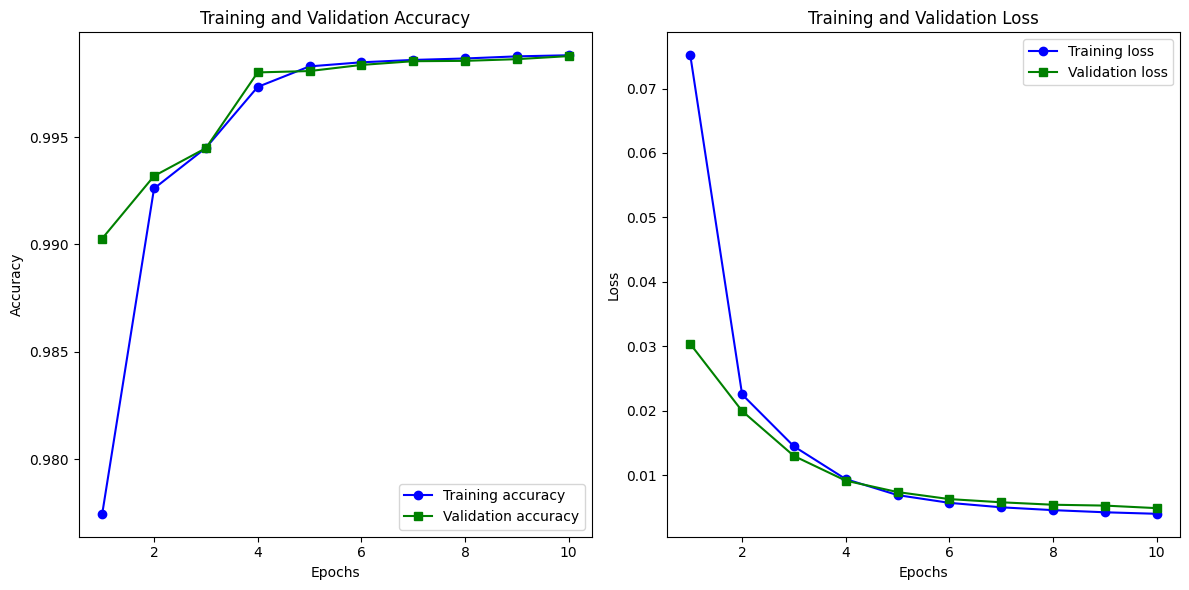

In [21]:
plot_lstm(history)

In [22]:
model_lstm.save("./models/kdd_model_lstm.keras")

In [23]:
dump(model_rfc, "./models/kdd_model_rfc.joblib")

['./models/kdd_model_rfc.joblib']

In [24]:
dump(model_gnb, "./models/kdd_model_gnb.joblib")

['./models/kdd_model_gnb.joblib']